# Text similarity evaluation

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('../../data/minors_with_preprocessed_descriptions.csv')

### Import embeddings

In [2]:
import joblib
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import tensorflow_hub as hub

# TF-IDF
tfidf_vectorizer = joblib.load('../../models/non_preprocessing/tfidf_vectorizer.pkl')

# Doc2Vec
doc2vec_model = Doc2Vec.load('../../models/non_preprocessing/doc2vec_model.model')

#USE
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

# sBERT
sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# sBERT fine-tuned
sbert_fine_tuned_model = SentenceTransformer('../../models/non_preprocessing/sbert_fine_tuned_model')

# RoBERTa
roberta_tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")
roberta_model = AutoModel.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

# RoBERTa fine-tuned
roberta_fine_tuned_model = SentenceTransformer('../../models/non_preprocessing/roberta_fine_tuned_model')

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid resu

In [3]:
models_list = [
    ('TF-IDF', tfidf_vectorizer),
    ('Doc2Vec', doc2vec_model),
    ('USE', use_model),
    ('sBERT', sbert_model),
    ('sBERT Fine-Tuned', sbert_fine_tuned_model),
    ('RoBERTa', roberta_model),
    ('RoBERTa Fine-Tuned', roberta_fine_tuned_model)
]

## 1. Semtantic Textual Similarity Spanish benchmark

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

def embed_sentences(sentences, model):
    if model == 'tfidf':
        return tfidf_vectorizer.transform(sentences).toarray()
    elif model == 'doc2vec':
        return np.array([doc2vec_model.infer_vector(sentence.split()) for sentence in sentences])
    elif model == 'use':
        return use_model(sentences).numpy()
    elif model == 'sbert':
        embeddings = sbert_model.encode(sentences, convert_to_tensor=True)
        return embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings
    elif model == 'sbert_fine_tuned':
        embeddings = sbert_fine_tuned_model.encode(sentences, convert_to_tensor=True)
        return embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings
    elif model == 'roberta':
        inputs = roberta_tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = roberta_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    elif model == 'roberta_fine_tuned':
        embeddings = roberta_fine_tuned_model.encode(sentences, convert_to_tensor=True)
        return embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings

# Embed sentences
def get_embeddings(dataset_split, model):
    sentence1_embeddings = embed_sentences(dataset_split['sentence1'], model)
    sentence2_embeddings = embed_sentences(dataset_split['sentence2'], model)
    return sentence1_embeddings, sentence2_embeddings


In [15]:
# Function to compute cosine similarity
def compute_cosine_similarity(embeddings1, embeddings2):
    return np.diag(cosine_similarity(embeddings1, embeddings2))

# Function to evaluate performance
def evaluate_performance(dataset_split, model_type):
    sentence1_embeddings, sentence2_embeddings = get_embeddings(dataset_split, model_type)
    cosine_similarities = compute_cosine_similarity(sentence1_embeddings, sentence2_embeddings)
    labels = np.array(dataset_split['label'])
    correlation = np.corrcoef(cosine_similarities, labels)[0, 1]
    return correlation


In [16]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("PlanTL-GOB-ES/sts-es", cache_dir='./datasets_cache', download_mode='force_redownload')
test_split = dataset['test']

Generating test split: 100%|██████████| 155/155 [00:00<00:00, 9921.06 examples/s]


In [17]:
def lowercase_text(example):
    example['sentence1'] = example['sentence1'].lower()
    example['sentence2'] = example['sentence2'].lower()
    return example

lowercased_test_split = test_split.map(lowercase_text)

Map: 100%|██████████| 155/155 [00:00<00:00, 9919.24 examples/s]


In [18]:
tfidf_score = evaluate_performance(lowercased_test_split, 'tfidf')
doc2vec_score = evaluate_performance(lowercased_test_split, 'doc2vec')
use_score = evaluate_performance(lowercased_test_split, 'use')
sbert_score = evaluate_performance(lowercased_test_split, 'sbert')
sbert_fine_tuned_score = evaluate_performance(lowercased_test_split, 'sbert_fine_tuned')
roberta_score = evaluate_performance(lowercased_test_split, 'roberta')
roberta_fine_tuned_score = evaluate_performance(lowercased_test_split, 'roberta_fine_tuned')

In [19]:
print("TF-IDF score:", tfidf_score)
print("Doc2Vec score:", doc2vec_score)
print("USE score:", use_score)
print("SBERT score:", sbert_score)
print("SBERT Fine-Tuned score:", sbert_fine_tuned_score)
print("RoBERTa score:", roberta_score)
print("RoBERTa Fine-Tuned score:", roberta_fine_tuned_score)

TF-IDF score: 0.6181539999962956
Doc2Vec score: 0.4123271541832502
USE score: 0.6766493983911013
SBERT score: 0.750840524739664
SBERT Fine-Tuned score: 0.7478287964328253
RoBERTa score: 0.41897201275041
RoBERTa Fine-Tuned score: 0.7117440794259561


## 2. CPV group similarity using test data

In [4]:
def calculate_similarity(model, descriptions):
    if model == tfidf_vectorizer:
        embeddings = model.transform(descriptions).toarray()
    elif model == doc2vec_model:
        embeddings = np.array([model.infer_vector(desc.split()) for desc in descriptions])
    elif model == use_model:
        embeddings = model(descriptions).numpy()
    elif model == sbert_model or model == sbert_fine_tuned_model:
        embeddings = model.encode(descriptions)
    elif model == roberta_model:
        inputs = roberta_tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    elif model == roberta_fine_tuned_model:
        embeddings = model.encode(descriptions)
    return embeddings

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

cpv_groups = df.groupby('CPV')
cpv_similarities = {}

for cpv, group in cpv_groups:
    descriptions = group['lowercase_description'].tolist()
    if len(descriptions) > 1:
        for name, model in models_list:
            embeddings = calculate_similarity(model, descriptions)
            cosine_sim_matrix = cosine_similarity(embeddings)
            avg_similarity = np.mean([cosine_sim_matrix[i, j] for i in range(len(cosine_sim_matrix)) for j in range(i+1, len(cosine_sim_matrix))])
            if name not in cpv_similarities:
                cpv_similarities[name] = []
            cpv_similarities[name].append(avg_similarity)

In [9]:
# Calculate overall average similarity for each model
overall_avg_similarity = {name: np.mean(similarities) for name, similarities in cpv_similarities.items()}

# Print the results
for name, avg_similarity in overall_avg_similarity.items():
    print(f"{name} Average Similarity: {avg_similarity:.4f}")

TF-IDF Average Similarity: 0.2724
Doc2Vec Average Similarity: 0.2569
USE Average Similarity: 0.6692
sBERT Average Similarity: 0.5708
sBERT Fine-Tuned Average Similarity: 0.7226
RoBERTa Average Similarity: 0.9679
RoBERTa Fine-Tuned Average Similarity: 0.6849


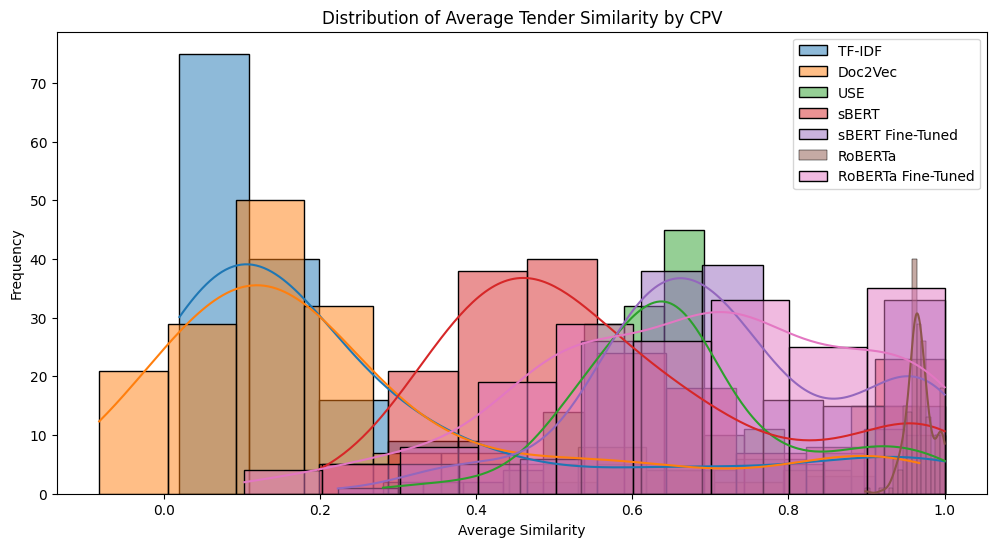

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the average tender similarity for each CPV
plt.figure(figsize=(12, 6))
for name, similarities in cpv_similarities.items():
    sns.histplot(similarities, label=name, kde=True)

plt.title('Distribution of Average Tender Similarity by CPV')
plt.xlabel('Average Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

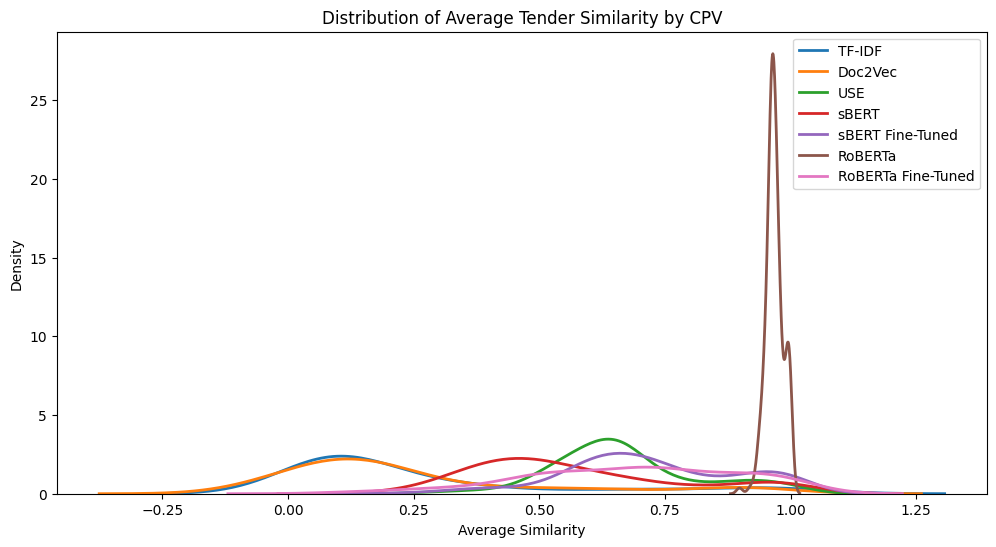

In [11]:
# Plot the distribution of the average tender similarity for each CPV without bars
plt.figure(figsize=(12, 6))
for name, similarities in cpv_similarities.items():
    sns.kdeplot(similarities, label=name, linewidth=2)

plt.title('Distribution of Average Tender Similarity by CPV')
plt.xlabel('Average Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()


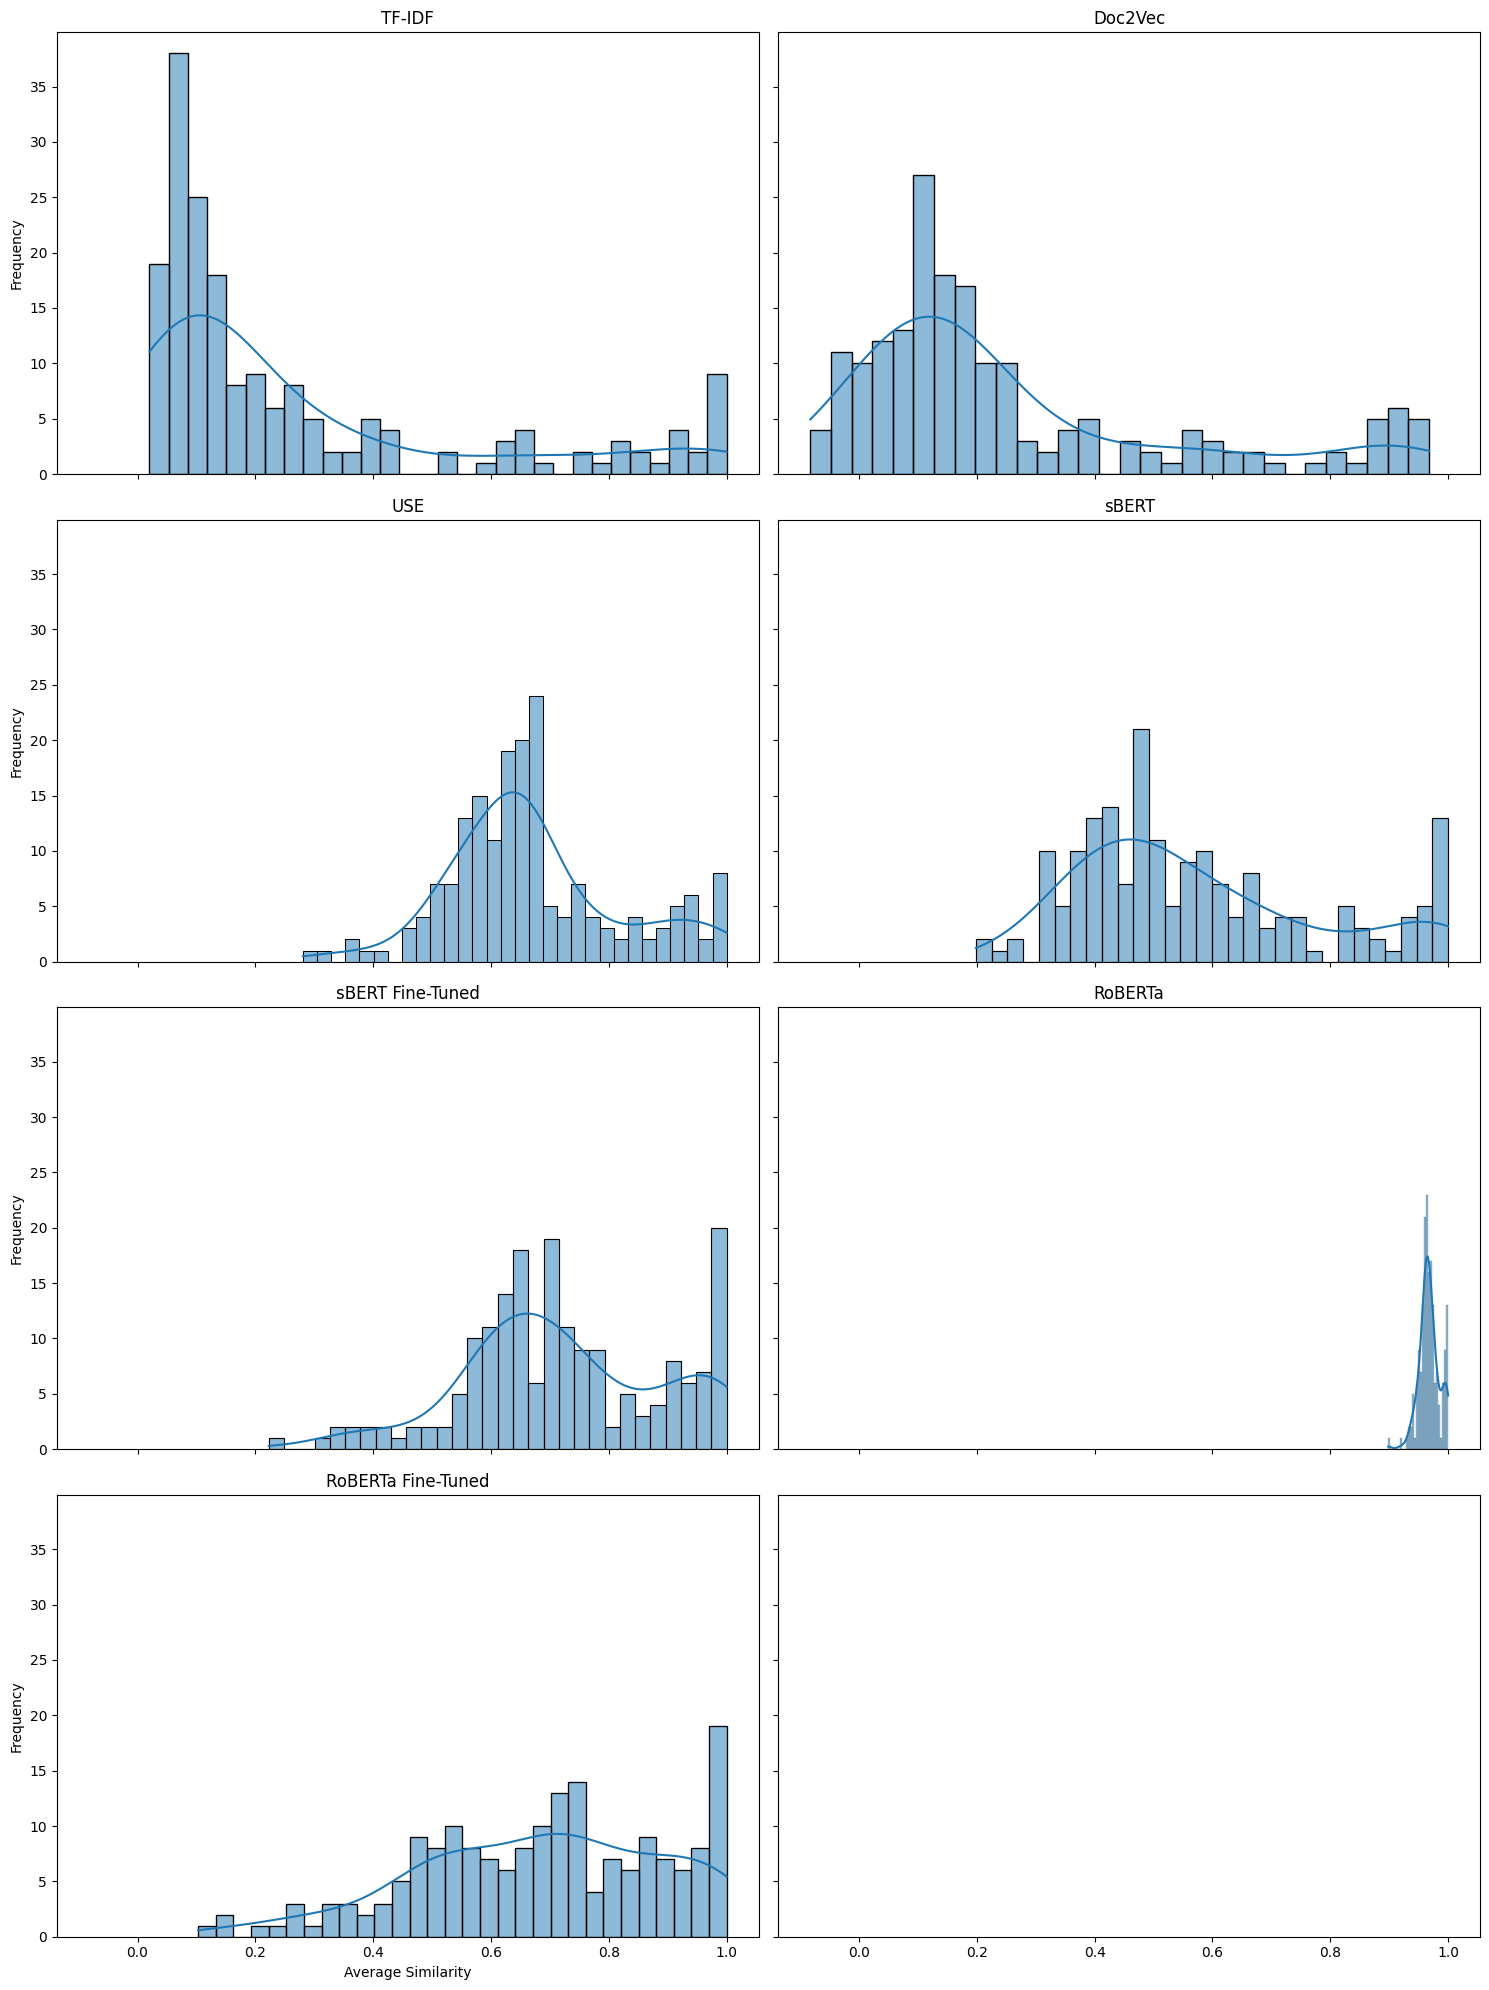

In [12]:
# Create a histogram for each model's similarity distribution
fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (name, similarities) in zip(axes, cpv_similarities.items()):
    sns.histplot(similarities, bins=30, kde=True, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Average Similarity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Cosine similarity between all tender descriptions pair-wise

In [14]:
descriptions = df['lowercase_description'].tolist()

# Calculate and print average pairwise cosine similarity for each model
for model_name, model in models_list:
    embeddings = calculate_similarity(model, descriptions)
    cosine_sim_matrix = cosine_similarity(embeddings)
    upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
    average_similarity = cosine_sim_matrix[upper_triangle_indices].mean()
    print(f"{model_name} Average Pairwise Cosine Similarity: {average_similarity}")

TF-IDF Average Pairwise Cosine Similarity: 0.06449322223809867
Doc2Vec Average Pairwise Cosine Similarity: 0.06395341455936432
USE Average Pairwise Cosine Similarity: 0.575329601764679
sBERT Average Pairwise Cosine Similarity: 0.30800697207450867
sBERT Fine-Tuned Average Pairwise Cosine Similarity: 0.26884886622428894
RoBERTa Average Pairwise Cosine Similarity: 0.9653798937797546
RoBERTa Fine-Tuned Average Pairwise Cosine Similarity: 0.1463959515094757


## 3. Clustering